<a href="https://colab.research.google.com/github/FreakForever/Shoppin_Assignment/blob/main/Shoppin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Video Frame Extraction, Sampling, Scene Change Detection, and Object Detection with YOLO Model**

---
This notebook demonstrates the following tasks for video processing:

1. Extracting frames from a video
2. Sampling frames uniformly
3. Detecting keyframes based on scene changes and similar cluster
4. Clustering frames to identify representative keyframes
5. Object detection on selected frames using YOLOv8
6. Displaying the processed images

**Reference**
1. SCD algo : [scene change detection](https://paperswithcode.com/task/scene-change-detection)

2. Code snippet : [kaggle](https://colab.research.google.com/drive/1Wxfhh7M7Q5BOq2Unamo6EBMIqrudjP3v?authuser=1#scrollTo=w6sTioxjADFR&line=16&uniqifier=1)
3. [Frame selection in short video](https://openaccess.thecvf.com/content_WACV_2020/papers/Ren_Best_Frame_Selection_in_a_Short_Video_WACV_2020_paper.pdf)

4. [Localization](https://arxiv.org/pdf/2004.12276)

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from google.colab import drive


In [ ]:
from ultralytics import YOLO


# Uploading Video

In [ ]:
from google.colab import files
import os
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]
print(f"Uploaded video file: {video_filename}")
output_frames_dir = 'extracted_frames'
os.makedirs(output_frames_dir, exist_ok=True)

Saving clothes.mp4 to clothes.mp4
Uploaded video file: clothes.mp4


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
def extract_frames(video_path, output_dir):
    """Extract all frames from the video."""
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(output_dir, f"frame_{i}.jpg")
        cv2.imwrite(frame_path, frame)
        frames.append((i, frame_path))
    cap.release()
    print(f"Extracted {len(frames)} frames.")
    return frames


In [ ]:
def uniform_sampling(frames, num_samples):
    step = len(frames) // num_samples
    return [frames[i] for i in range(0, len(frames), step)][:num_sample

In [ ]:
def scene_change_detection(frames, threshold=0.9):
    """Detect frames with significant scene changes."""
    key_frames = []
    prev_hist = None
    for idx, frame_path in frames:
        frame = cv2.imread(frame_path)
        hist = cv2.calcHist([frame], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        if prev_hist is None or cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CORREL) < threshold:
            key_frames.append((idx, frame_path))
            prev_hist = hist
    print(f"Scene Change Detected Frames: {len(key_frames)}")
    return key_frames[:20]

In [ ]:
def keyframe_clustering(frames, num_clusters=10):
    """Cluster frames based on visual features and select representative frames."""
    features = []

    for idx, frame_path in frames:
        frame = cv2.imread(frame_path)
        resized = cv2.resize(frame, (128, 128)).flatten()
        features.append(resized)
    n_components = min(20, len(features))
    features = PCA(n_components=n_components).fit_transform(features)
    kmeans = KMeans(n_clusters=num_clusters).fit(features)

    clusters = [[] for _ in range(num_clusters)]
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(frames[i])
    keyframes = [cluster[0] for cluster in clusters if cluster]
    return keyframes

In [ ]:
def detect_objects_no_labels(frame_paths, model_name="yolo11n", output_dir="detected_frames"):
    """
    Perform object detection using YOLOv11 and save images with bounding boxes (excluding labels).
    Args:
        frame_paths (list): List of frame paths to process.
        model_name (str): YOLOv8 model to use ('yolov11n', 'yolov11s', etc.).
        output_dir (str): Directory to save output images with bounding boxes.
    Returns:
        detected_images (list): Paths to images with detections.
    """
    os.makedirs(output_dir, exist_ok=True)
    model = YOLO(model_name)
    detected_images = []
    for frame_path in frame_paths:
        results = model(frame_path)
        image = cv2.imread(frame_path)
        for box in results[0].boxes.data:
            x1, y1, x2, y2, conf, cls = box
            class_name = results[0].names[int(cls)]
            if class_name.lower() == "person":
                continue
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        save_path = os.path.join(output_dir, os.path.basename(frame_path))
        cv2.imwrite(save_path, image)
        detected_images.append(save_path)
        print(f"Saved detected image (no labels): {save_path}")
    return detected_images


def display_images(image_paths, title="Detected Images"):
    """Display images with bounding boxes."""
    for image_path in image_paths:
        image = cv2.imread(image_path)
        cv2_imshow(image)
        print(f"Displayed: {image_path}")

Extracting frames from the uploaded video...
Extracted 1475 frames.
Selecting frames using Scene Change Detection...
Scene Change Detected Frames: 62
Optimizing frame selection using Clustering...
Performing Object Detection on selected frames (excluding labels)...


100%|██████████| 21.5M/21.5M [00:00<00:00, 94.7MB/s]



image 1/1 /content/extracted_frames/frame_31.jpg: 640x640 2 persons, 1 chair, 16.5ms
Speed: 4.3ms preprocess, 16.5ms inference, 1061.0ms postprocess per image at shape (1, 3, 640, 640)
Saved detected image (no labels): detected_frames/frame_31.jpg

image 1/1 /content/extracted_frames/frame_415.jpg: 640x640 2 persons, 1 chair, 1 vase, 16.6ms
Speed: 4.6ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Saved detected image (no labels): detected_frames/frame_415.jpg

image 1/1 /content/extracted_frames/frame_146.jpg: 640x640 2 persons, 1 suitcase, 1 chair, 17.9ms
Speed: 4.7ms preprocess, 17.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Saved detected image (no labels): detected_frames/frame_146.jpg

image 1/1 /content/extracted_frames/frame_430.jpg: 640x640 2 persons, 1 chair, 16.4ms
Speed: 3.2ms preprocess, 16.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Saved detected image (no labels): detected_frames/f

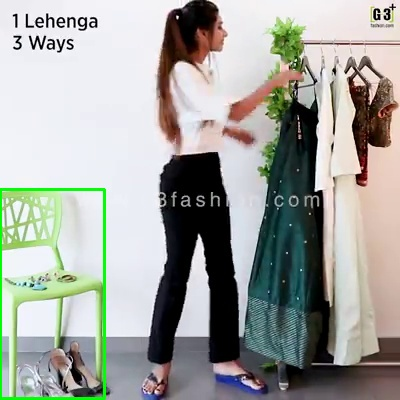

Displayed: detected_frames/frame_31.jpg


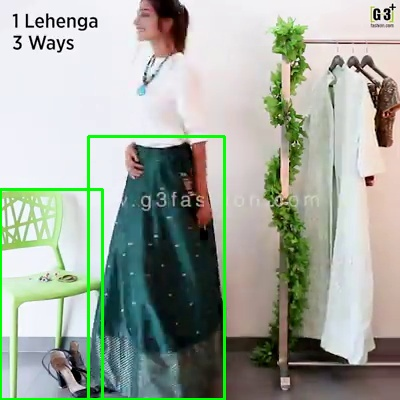

Displayed: detected_frames/frame_415.jpg


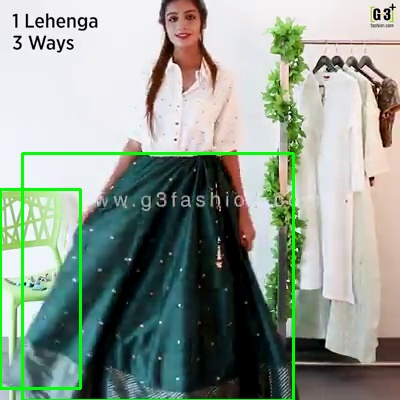

Displayed: detected_frames/frame_146.jpg


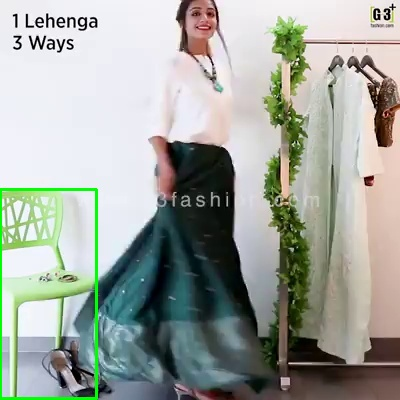

Displayed: detected_frames/frame_430.jpg


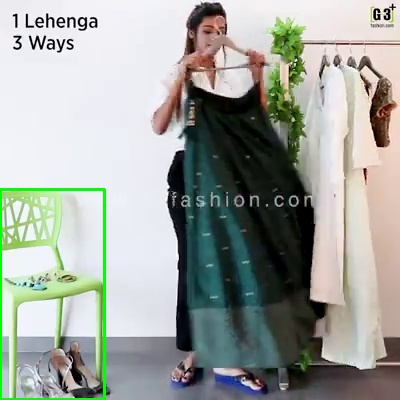

Displayed: detected_frames/frame_50.jpg


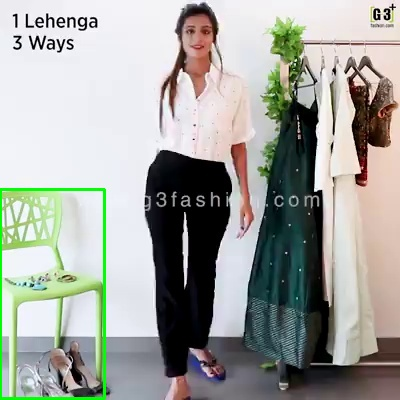

Displayed: detected_frames/frame_0.jpg


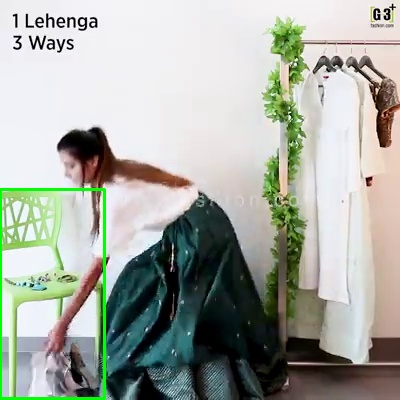

Displayed: detected_frames/frame_190.jpg


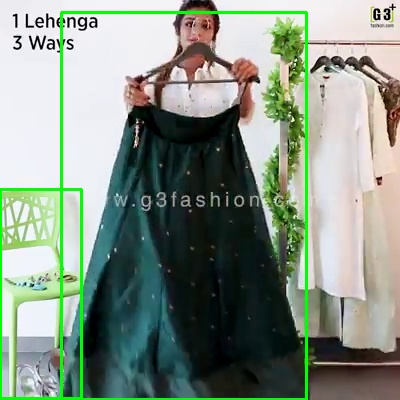

Displayed: detected_frames/frame_70.jpg


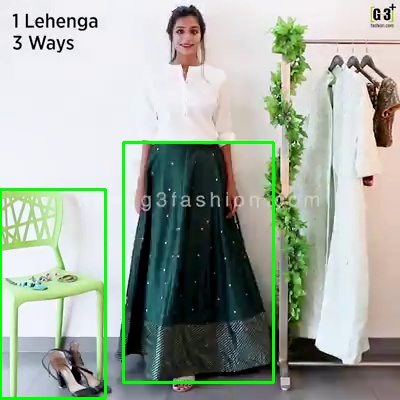

Displayed: detected_frames/frame_334.jpg


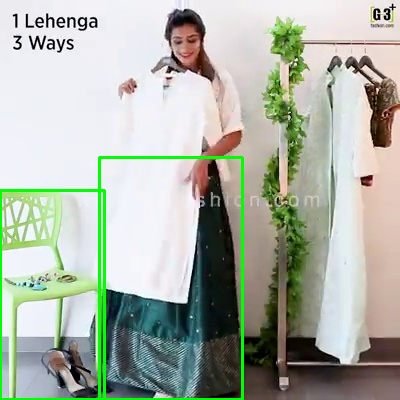

Displayed: detected_frames/frame_330.jpg


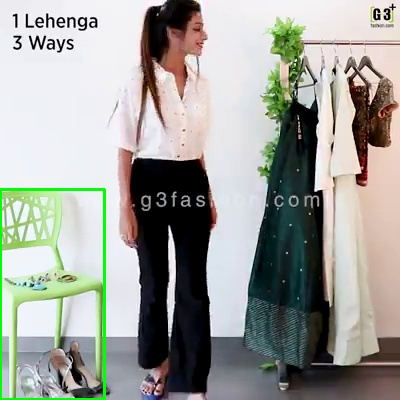

Displayed: detected_frames/frame_21.jpg


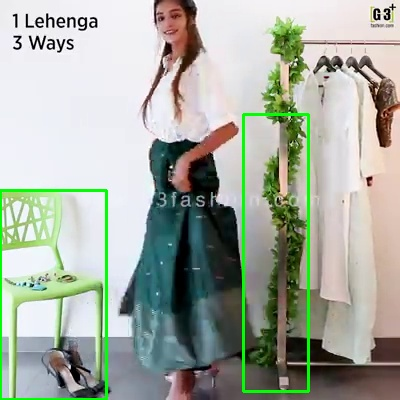

Displayed: detected_frames/frame_241.jpg


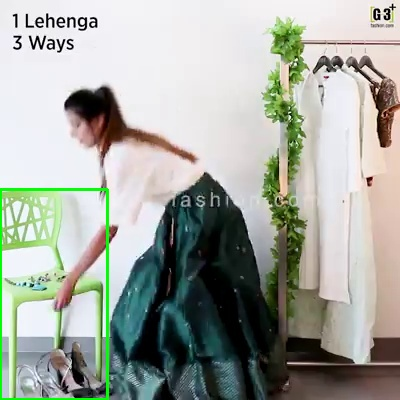

Displayed: detected_frames/frame_182.jpg


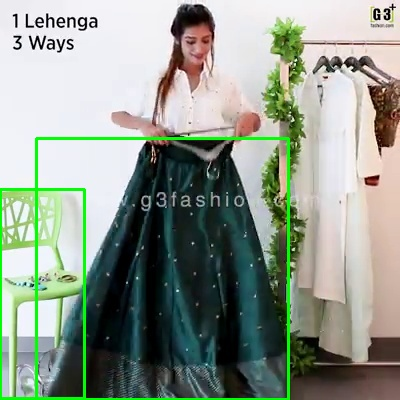

Displayed: detected_frames/frame_88.jpg


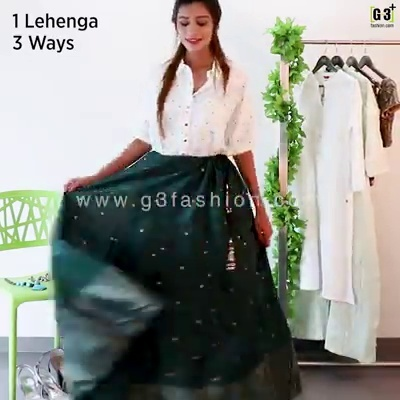

Displayed: detected_frames/frame_139.jpg


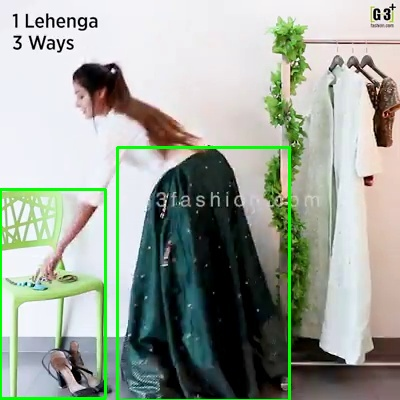

Displayed: detected_frames/frame_383.jpg


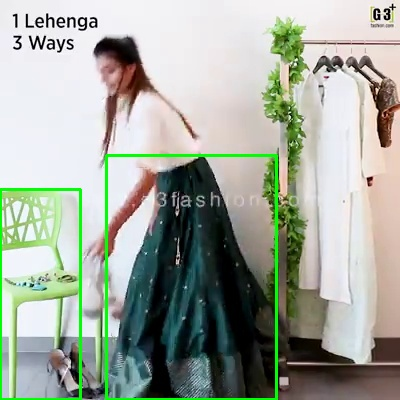

Displayed: detected_frames/frame_196.jpg


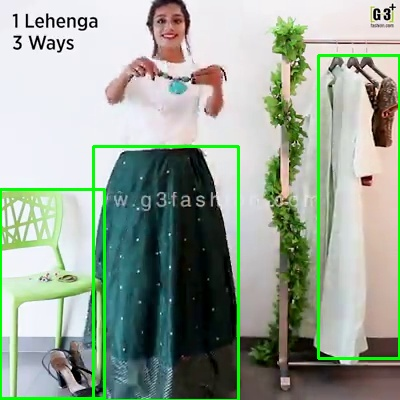

Displayed: detected_frames/frame_406.jpg


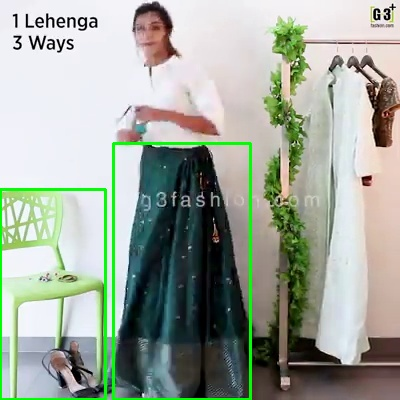

Displayed: detected_frames/frame_396.jpg


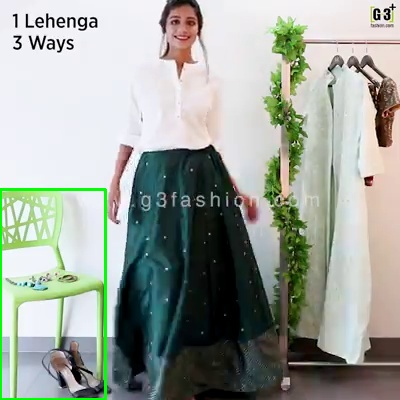

Displayed: detected_frames/frame_348.jpg


In [ ]:
def main():
    output_frames_dir = 'extracted_frames'
    detected_output_dir = 'detected_frames'
    os.makedirs(detected_output_dir, exist_ok=True)
    print("Extracting frames from the uploaded video...")
    frames = extract_frames(video_filename, output_frames_dir)

    num_samples = 20 # As per the question. If the video is in 15fps.
    print("Selecting frames using Scene Change Detection...")
    selected_frames = scene_change_detection(frames)
    if len(selected_frames) < num_samples:
        print("Using Uniform Sampling to fill remaining frames...")
        remaining_frames = uniform_sampling([f for f in frames if f not in selected_frames],
                                            num_samples - len(selected_frames))
        selected_frames.extend(remaining_frames)
    print("Optimizing frame selection using Clustering...")
    selected_frames = keyframe_clustering(selected_frames, num_clusters=num_samples)
    print("Performing Object Detection on selected frames (excluding labels)...")
    frame_paths = [frame[1] for frame in selected_frames]
    detected_images = detect_objects_no_labels(frame_paths, model_name="yolov8s", output_dir=detected_output_dir)
    print("\n--- Detection Results ---")
    for frame_path in detected_images:
        print(f"Detected and saved frame: {frame_path}")
    print("\nDisplaying detected images with bounding boxes...")
    display_images(detected_images)

if __name__ == "__main__":
    video_filename =  "clothes.mp4"
    main()

# Training YOLO model with custom fashion dataset

---

- In this section I have taken custom datasets from roboflow and then have trained the yolov11 model.

**Reason**

1.   Improving accuracy of detection
2.   Anchor-free detection	Precise bounding box predictions.

For more info : [ultralytics](https://docs.ultralytics.com/modes/val/#usage-examples)



In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="u8YCgeJYHzzjyrVeB16p")
project = rf.workspace("fashionistai").project("fashionistai-jd7el")
version = project.version(1)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fashionistAI-1 in yolov8:: 100%|██████████| 4448/4448 [00:00<00:00, 8329.40it/s]


In [ ]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")
results = model.train(data="/content/fashionistAI-1/data.yaml", epochs=10, imgsz=640)

100%|██████████| 5.35M/5.35M [00:00<00:00, 116MB/s]


Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/fashionistAI-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

100%|██████████| 755k/755k [00:00<00:00, 82.6MB/s]


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/fashionistAI-1/train/labels... 1699 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1699/1699 [00:01<00:00, 1565.36it/s]


train: New cache created: /content/fashionistAI-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/fashionistAI-1/valid/labels... 328 images, 0 backgrounds, 0 corrupt: 100%|██████████| 328/328 [00:00<00:00, 1761.88it/s]


val: New cache created: /content/fashionistAI-1/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.9774      3.921      1.457          3        640: 100%|██████████| 107/107 [24:54<00:00, 13.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [01:43<00:00,  9.42s/it]

                   all        328        639      0.722      0.157      0.155      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G       0.96        3.4      1.374         37        640:   2%|▏         | 2/107 [00:28<24:58, 14.27s/it]

In [ ]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
display.clear_output()


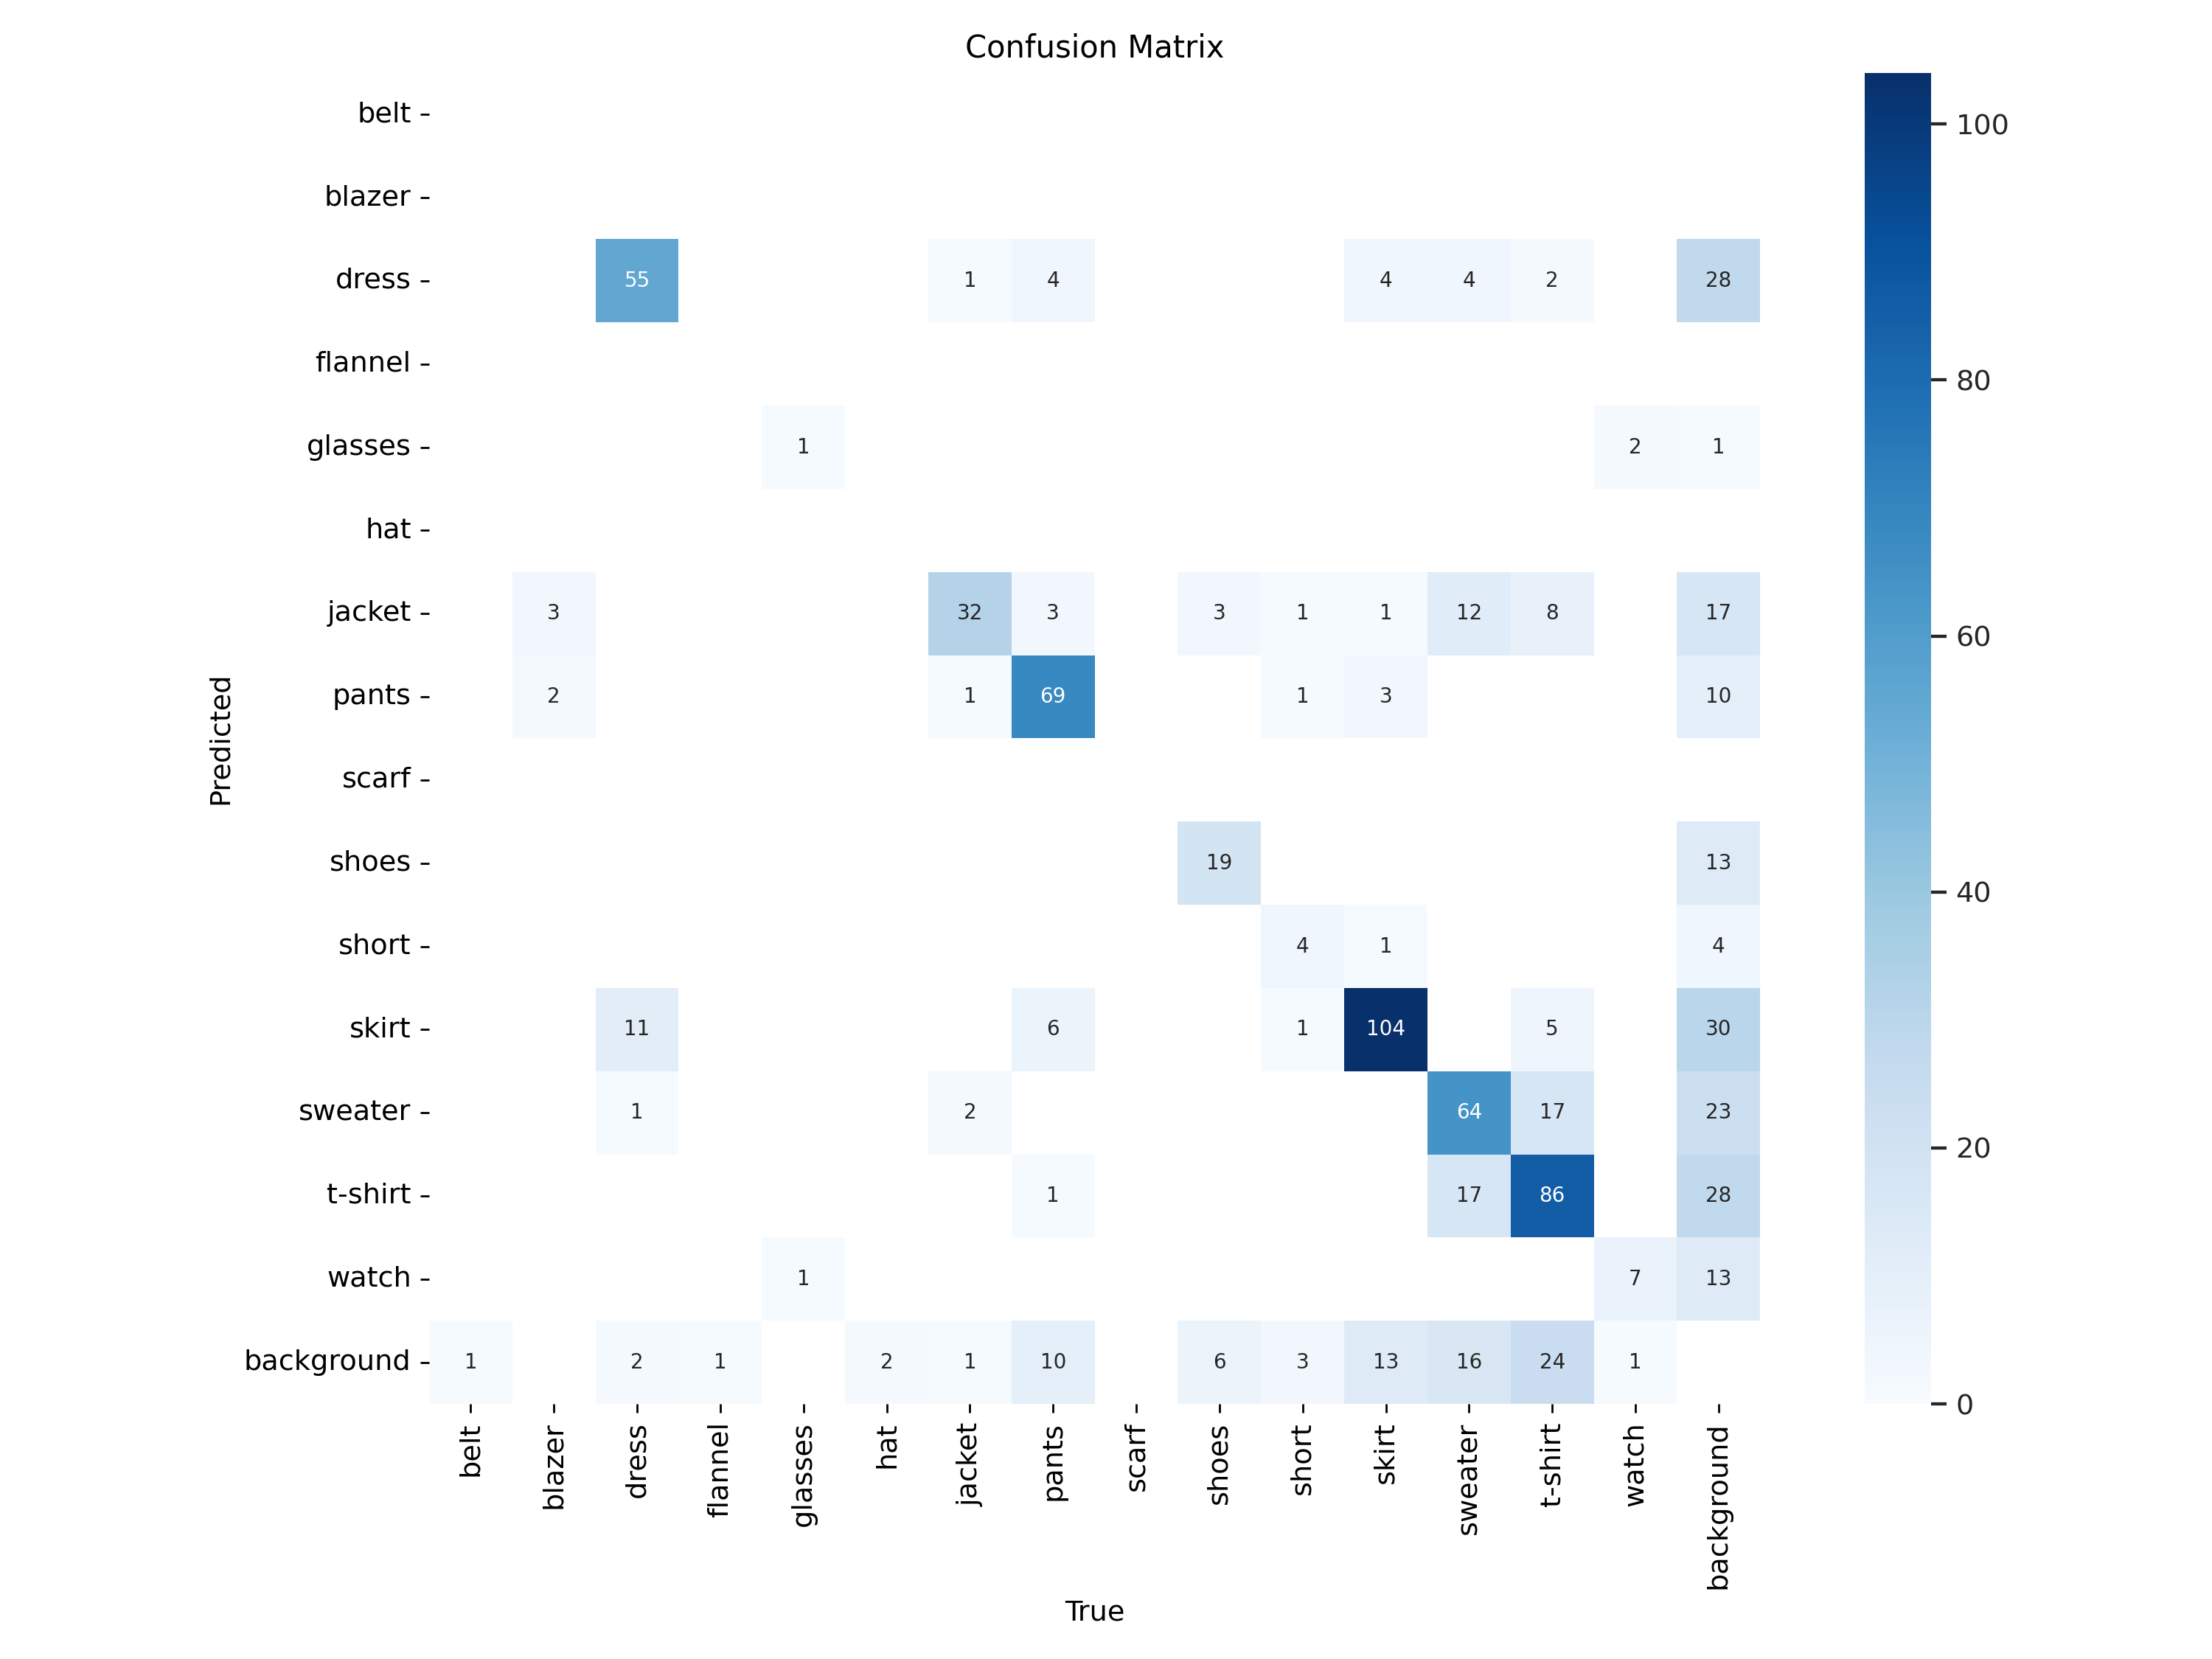

In [ ]:
Image(filename = f'/content/runs/detect/train/confusion_matrix.png', width = 600)


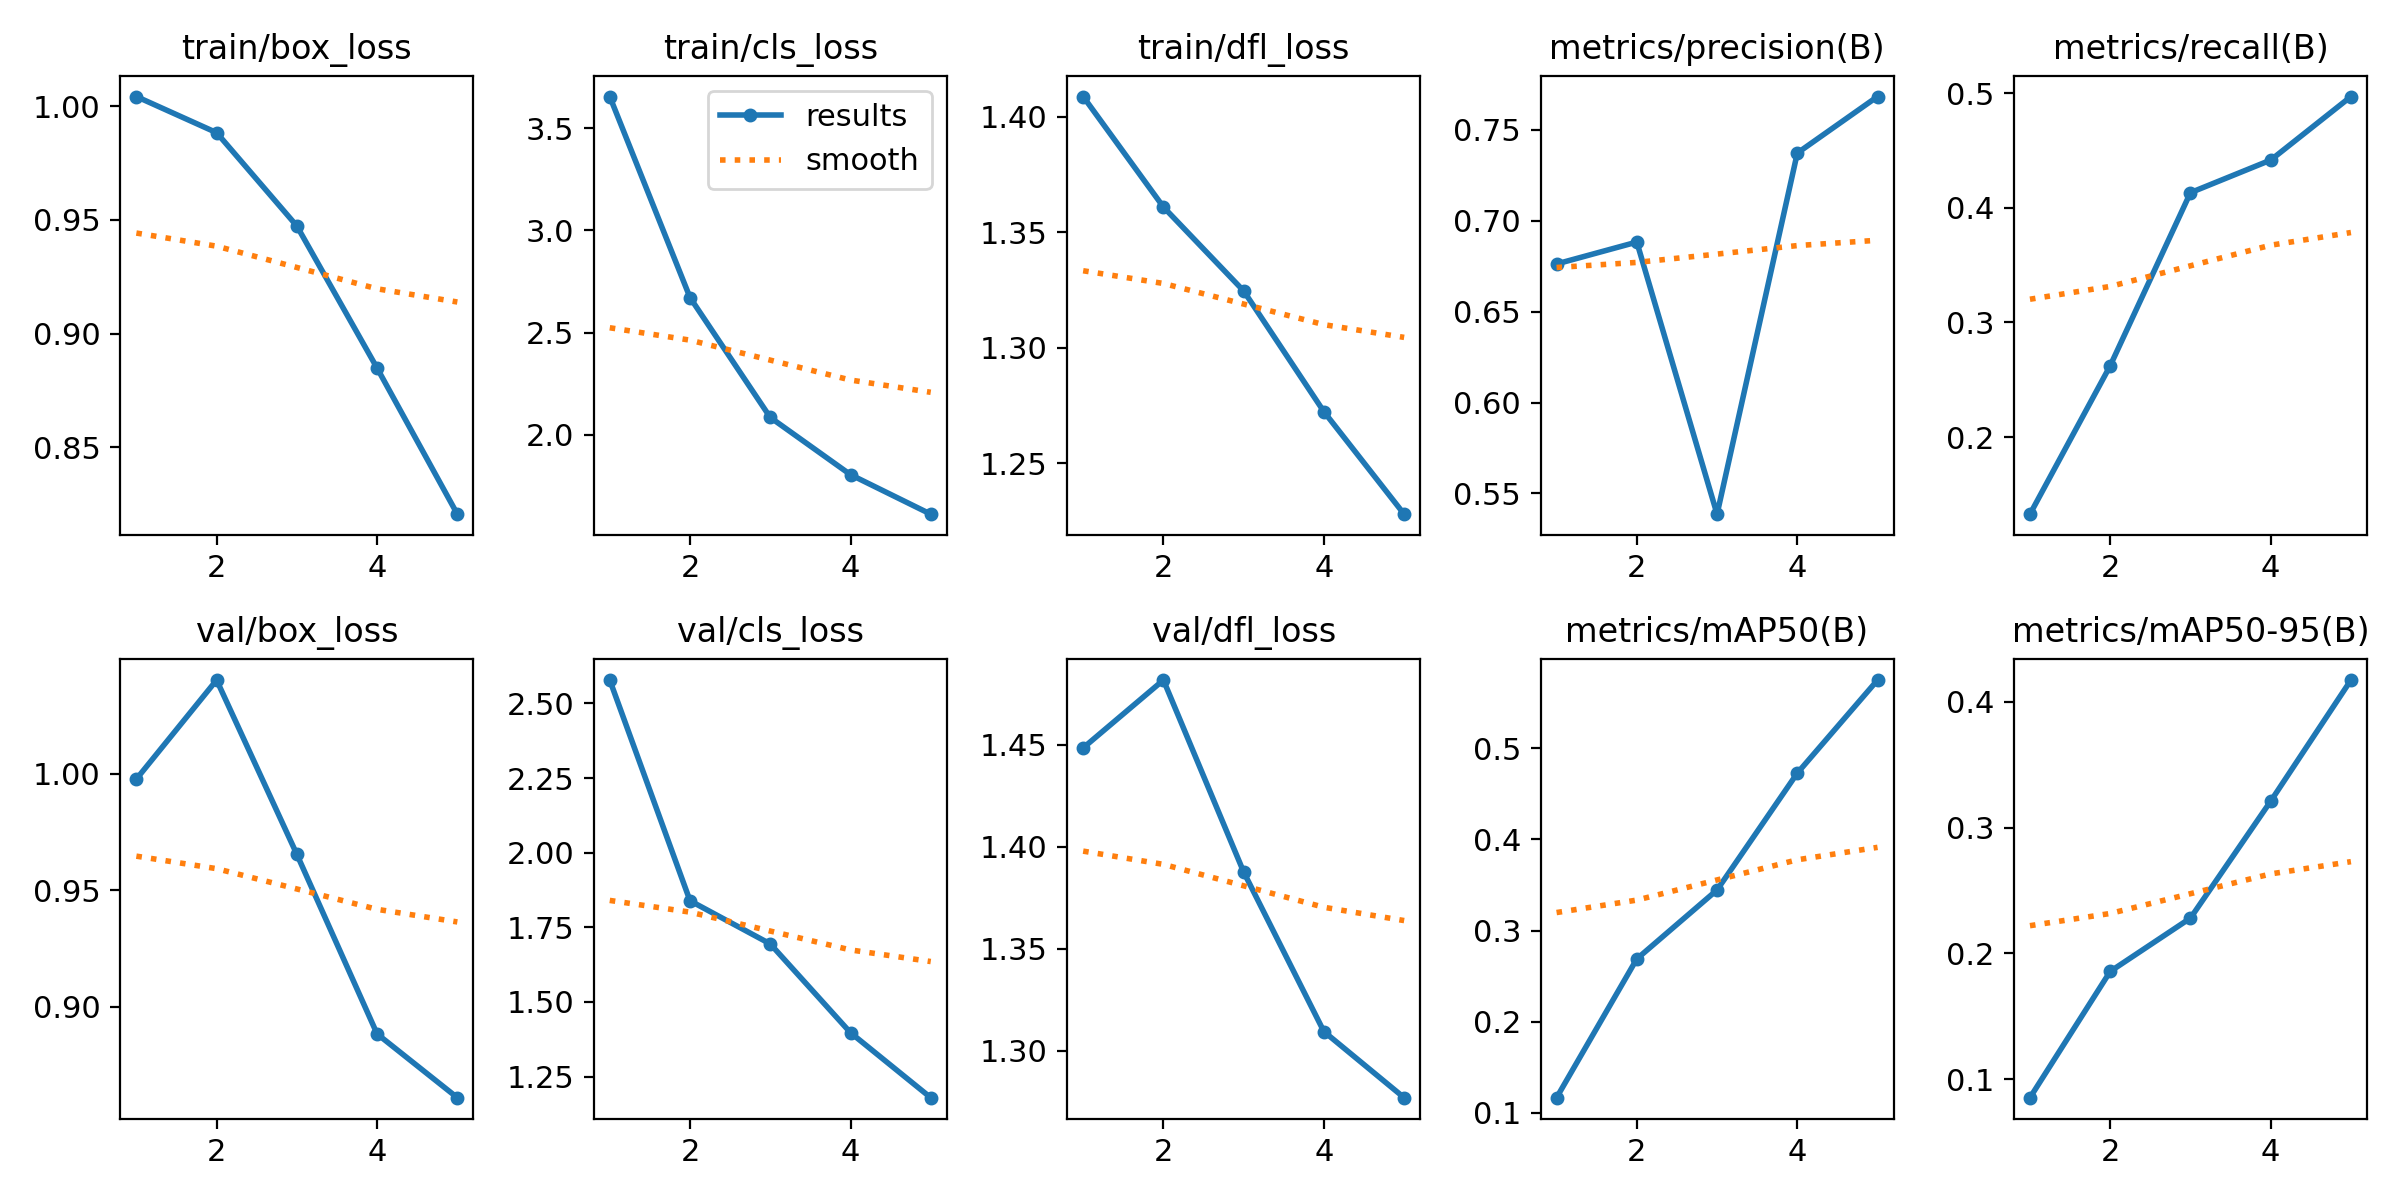

In [ ]:
Image(filename = f'/content/runs/detect/train/results.png', width = 600)